hello 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [49]:
dfB = pd.read_csv("Data-Table 1.csv",thousands=',')
dfW = pd.read_csv("london_weather.csv",parse_dates=["date"])

In [50]:
dfB = dfB.drop(columns = ['Unnamed: 2','Month','Number of Bicycle Hires.1', 'Unnamed: 5', 'Year',
       'Number of Bicycle Hires.2', 'Unnamed: 8', 'Month.1',
       'Average Hire Time (mins)', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'])


In [53]:
dfB = dfB.convert_dtypes()
dfB["Day"] = pd.to_datetime(dfB["Day"])
dfW = dfW.convert_dtypes()
dfW["date"] = pd.to_datetime(dfW["date"])


In [54]:
print(dfW['date'][0])
print(dfW['date'][-1:])
print(dfB['Day'][0])
print(dfB['Day'][-1:])

dfW = dfW[~(dfW['date'] < '2010-07-30')]
dfB = dfB[~(dfB['Day'] > '2020-12-31')]

1979-01-01 00:00:00
15340   2020-12-31
Name: date, dtype: datetime64[ns]
2010-07-30 00:00:00
4537   2022-12-31
Name: Day, dtype: datetime64[ns]


In [60]:
dfB = dfB.set_index("Day")
dfW = dfW.set_index("date")

In [61]:
dfW.info()
dfB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       3808 non-null   float64
 1   sunshine          3808 non-null   Float64
 2   global_radiation  3802 non-null   Int64  
 3   max_temp          3802 non-null   Float64
 4   mean_temp         3801 non-null   Float64
 5   min_temp          3806 non-null   Float64
 6   precipitation     3802 non-null   Float64
 7   pressure          3808 non-null   Int64  
 8   snow_depth        3171 non-null   Int64  
dtypes: Float64(5), Int64(3), float64(1)
memory usage: 327.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Number of Bicycle Hires  3808 non-null   Int64
dtypes: Int64(1

<AxesSubplot: xlabel='date', ylabel='snow_depth'>

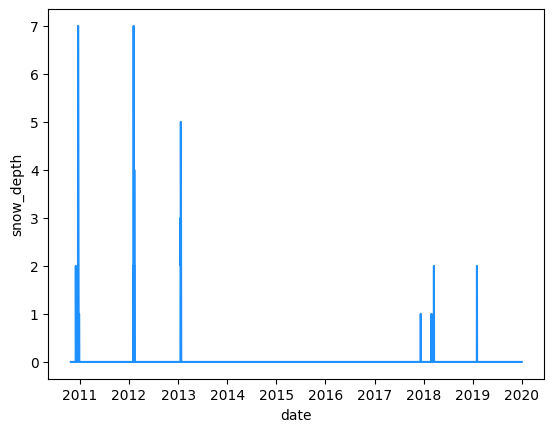

In [43]:
sns.lineplot(x=dfW.index, y=dfW["snow_depth"],  color='dodgerblue')

<AxesSubplot:xlabel='ob_end_time', ylabel='prcp_amt'>

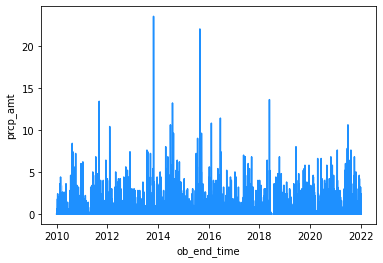

In [119]:
sns.lineplot(x=dfW["ob_end_time"], y=dfW["prcp_amt"],  color='dodgerblue')

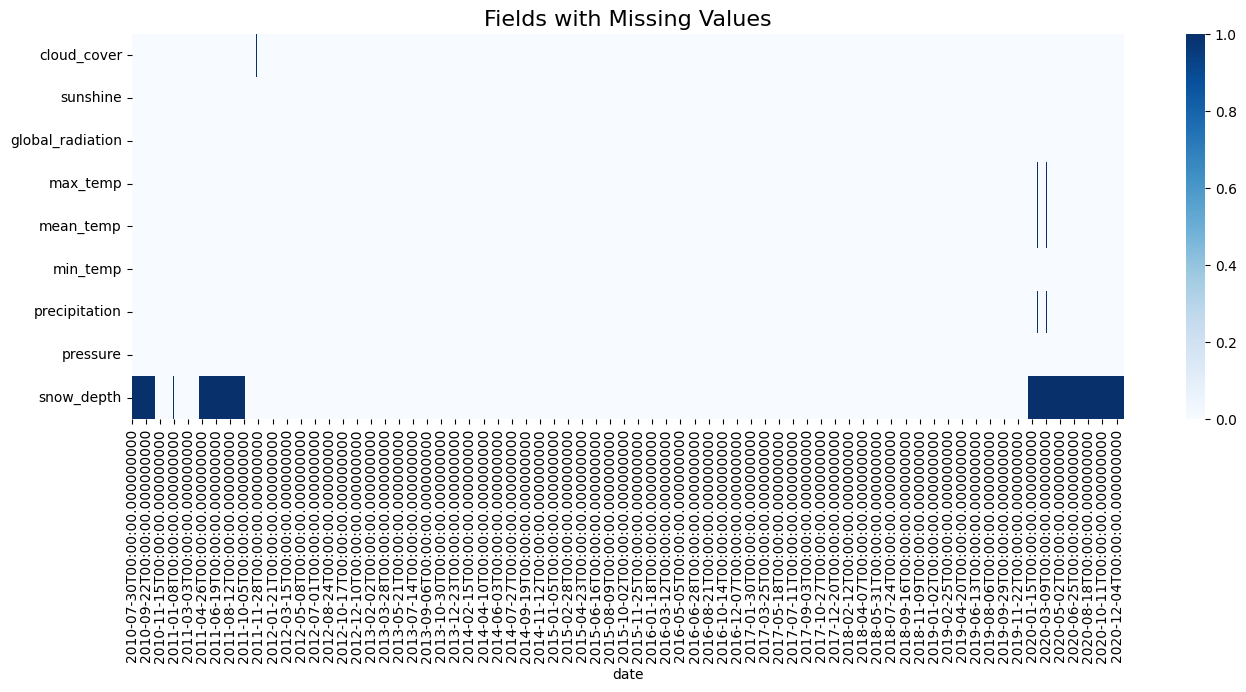

In [44]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(dfW.isna().transpose(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
plt.show()

In [62]:
dfW.isna().sum()


cloud_cover           0
sunshine              0
global_radiation      6
max_temp              6
mean_temp             7
min_temp              2
precipitation         6
pressure              0
snow_depth          637
dtype: int64

In [65]:
dfW["cloud_cover"] = dfW["cloud_cover"].values.astype(float)
dfW["global_radiation"] = dfW["global_radiation"].values.astype(float)
dfW["max_temp"] = dfW["max_temp"].values.astype(float)
dfW["mean_temp"] = dfW["mean_temp"].values.astype(float)
dfW["min_temp"] = dfW["min_temp"].values.astype(float)
dfW["precipitation"] = dfW["precipitation"].values.astype(float)
dfW["snow_depth"] = dfW["snow_depth"].values.astype(float)


dfW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       3808 non-null   float64
 1   sunshine          3808 non-null   Float64
 2   global_radiation  3802 non-null   float64
 3   max_temp          3802 non-null   float64
 4   mean_temp         3801 non-null   float64
 5   min_temp          3806 non-null   float64
 6   precipitation     3802 non-null   float64
 7   pressure          3808 non-null   Int64  
 8   snow_depth        3171 non-null   float64
dtypes: Float64(1), Int64(1), float64(7)
memory usage: 304.9 KB


In [66]:
dfW['cloud_cover'] = dfW['cloud_cover'].interpolate()
dfW['global_radiation'] = dfW['global_radiation'].interpolate()
dfW['max_temp'] = dfW['max_temp'].interpolate()
dfW['mean_temp'] = dfW['mean_temp'].interpolate()
dfW['min_temp'] = dfW['min_temp'].interpolate()
dfW['precipitation'] = dfW['precipitation'].interpolate()
dfW['snow_depth'] = dfW['snow_depth'].interpolate()


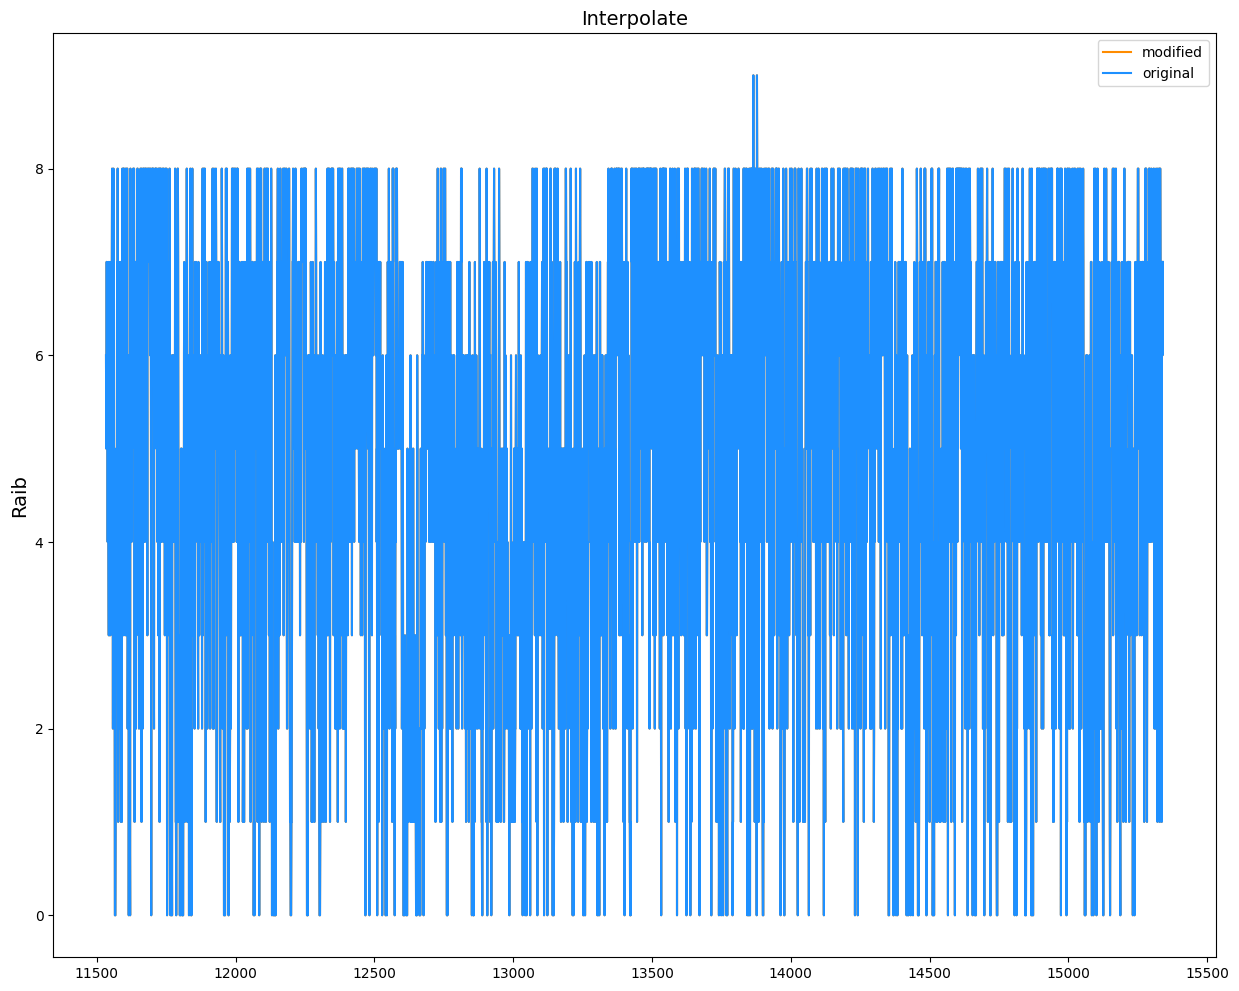

In [59]:
data = dfW
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
sns.lineplot(x=data.index, y=data.cloud_cover.interpolate(),color='darkorange', label = 'modified')
sns.lineplot(x=data.index, y=data.cloud_cover.fillna(np.inf),  color='dodgerblue', label = 'original')
ax.set_title(f'Interpolate', fontsize=14)
ax.set_ylabel(ylabel='Raib', fontsize=14)
plt.show()

In [123]:
print(dfW.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104426 entries, 0 to 113117
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ob_end_time  104426 non-null  datetime64[ns]
 1   prcp_amt     104398 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 MB
None


In [124]:
print(dfW[dfW.isnull().any(axis=1)])

              ob_end_time  prcp_amt
16238 2011-09-23 09:00:00       NaN
16239 2011-09-23 10:00:00       NaN
36092 2013-11-07 12:00:00       NaN
38795 2014-02-19 11:00:00       NaN
38796 2014-02-19 12:00:00       NaN
38797 2014-02-19 13:00:00       NaN
45529 2014-11-05 12:00:00       NaN
45530 2014-11-05 13:00:00       NaN
45531 2014-11-05 14:00:00       NaN
50051 2015-04-28 10:00:00       NaN
50052 2015-04-28 11:00:00       NaN
50053 2015-04-28 12:00:00       NaN
50054 2015-04-28 13:00:00       NaN
61203 2016-06-30 10:00:00       NaN
70434 2017-06-21 11:00:00       NaN
70435 2017-06-21 12:00:00       NaN
73372 2017-10-12 11:00:00       NaN
73373 2017-10-12 12:00:00       NaN
74231 2017-11-14 13:00:00       NaN
76464 2018-02-08 13:00:00       NaN
79902 2018-06-29 11:00:00       NaN
79903 2018-06-29 12:00:00       NaN
79904 2018-06-29 13:00:00       NaN
84427 2018-12-20 12:00:00       NaN
84428 2018-12-20 13:00:00       NaN
87506 2019-04-17 22:00:00       NaN
88430 2019-05-24 12:00:00   

In [125]:
print(type(dfW))

<class 'pandas.core.frame.DataFrame'>


In [126]:
dfW['prcp_amt'] = dfW['prcp_amt'].interpolate()

In [148]:
dfW_down = dfW.resample("D", on='ob_end_time').sum()

In [149]:
print(dfW.info())
print(dfW_down.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104426 entries, 0 to 113117
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ob_end_time  104426 non-null  datetime64[ns]
 1   prcp_amt     104426 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2010-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   prcp_amt  4383 non-null   float64
dtypes: float64(1)
memory usage: 68.5 KB
None
